# Title: Add title here
*2023 datathon and conference on Efficient Data Analysis for the Condition Assessment of Bridges*

**Author(s):** Add author name here

**Affiliation(s):** Add author affiliation here



## Abstract
Write abstract here.

## Content
Write the main body of Notebook text below this point.

### Headings and subheadings
To break your document into sections use "##" for section headings and "###" for section subheadings. 

To write *italic* text, enclose the text in "\*". 

To write **bold** text, enclose the text in "\*\*".

### Bullet points and numbered lists

- This is an example of a bullet point.
- This is another example of a bullet point.
    - This is an example of a subpoint

1. This is an example of a numbered list.
1. This continues the numbered list.
    1. This is an example of a nested list.
    1. This is a further subpoint.

### Including equations in Jupyter Notebooks
Notebooks use *LaTex* text formatting. Equations can be written inline, such as $e=mc^2$, or as seperate equation blocks as shown below.

$y = Ax+C$

### Including hyperlinks in Jupyter Notebooks
We can include hyperlinks through combinations of square and rounded brackets like [this](https://blogs.ed.ac.uk/edacab/).

### Including tables in Jupyter Notebooks
Tables use the notation shown below:

| Column 1 | Column 2 | Column 3 |
| --- | --- | --- |
| Value 1 | Description 1  | A note |
| Value 2 | Description 2  | A much longer note to demonstrate how columns expand as needed |
| Value 3 | Description 3  | A third note.|
| Value 4 | Description 4  | A further note |

### Including images in Jupyter Notebooks

To include images we upload them to the notebook and reference them using the HTML code shown below.

<div><center>
    <img src="./Example_Image.JPG" width="25%"/>
</center></div>

### Further help
For further guidance on writing Jupter Notebooks refer to [this guide](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) or [this summary](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet).

## Adding Python code to Jupyter Notebooks
To add Python code to Jupyter notebooks we define a new *code block*. This block behaves like a typical Python interpreter, allowing us to import Python libraries, write function, or define variables. An example block of code is shown below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def example_function(input_data):
    output_data = input_data**2
    return output_data

dat = np.arange(100)
output_dat = example_function(dat)
print('The first ten output values are: '+str(output_dat[:10]))

The first ten output values are: [ 0  1  4  9 16 25 36 49 64 81]


Any variables or functions we have previously defined in carry over to future code blocks, as shown below.

In [2]:
print('The first ten output values are still: '+str(output_dat[:10]))

The first ten output values are still: [ 0  1  4  9 16 25 36 49 64 81]


We can plot figures inline to help demonstrate relationships between variables.

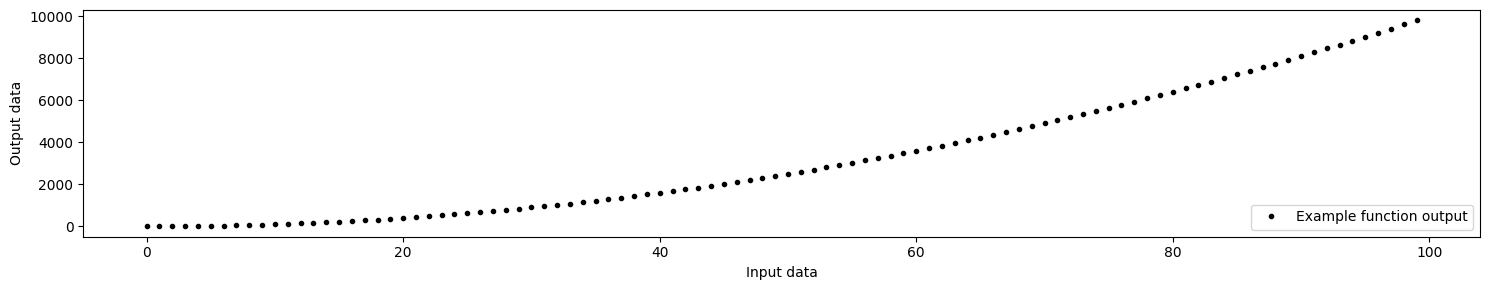

In [3]:
fg,ax = plt.subplots(figsize=(15,3))
ax.plot(dat,output_dat,'k.',label='Example function output')
ax.set_ylabel('Output data')
ax.set_xlabel('Input data')
ax.legend(loc=4)
fg.tight_layout()

## Accessing the LT2 footbridge livestream data
To access the LT2 footbridge livestream data via DeepNote we first need to install the [socketio](https://python-socketio.readthedocs.io/en/latest/) library.


In [5]:
pip install "python-socketio[client]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 KB 12.3 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The block of code below establishes a socket connection to the LT2 smart bridge and provides the building blocks necessary to interact with data from the structure. The code below will run for 20 seconds and update the plot each time new data is recieved.

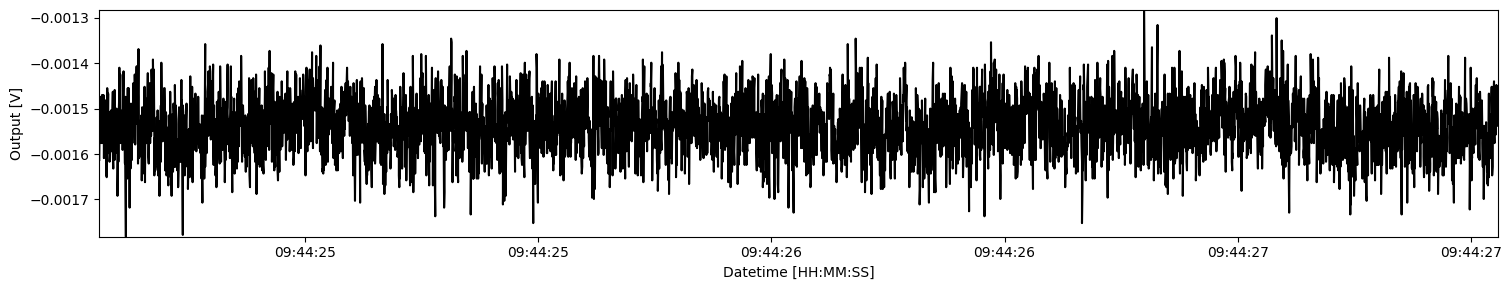

In [8]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global t,x0
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]
    # Extract the raw acceleration data (in volts)
    x0 = np.array(eval(dat[len(t_stamp):]))
    # Create a time array using the time stamp
    t0 = np.arange(float(t_stamp)-(len(x0[0])/fs),float(t_stamp),1/fs)
    # Convert the time from UNIX time to a NumPy datetime format
    t = (t0*1000).astype('datetime64[ms]') # Note we need to multiply by 1000 to convert from seconds to milliseconds
    
sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

x0 = np.zeros((1,1)) # A dummy array used for creating the plot before we've recieved data
t = np.zeros(1) # A dummy array used for creating the plot before we've recieved data

time_to_disconnect = 20
time_start = time.time()
fs = 1707.76 # Sample rate of the data

# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.plot(t,x0[0],c='k')
ax.set_ylabel('Output [V]')
ax.set_xlabel('Datetime [HH:MM:SS]')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) # Set the formatting of the datetime x-axis

fg.tight_layout()
plt.pause(0.01)
while time.time()-time_start<time_to_disconnect:
    if len(t)>1:
        try:
            plotted_data.set_data(t,x0[0]) # Update the plotted data
            ax.set_xlim(np.min(t),np.max(t)) # Update the x-axis of the plot
            ax.set_ylim(np.min(x0[0]),np.max(x0[0])) # Update the y-axis of the plot
            display(fg) # Update the displayed plot
            clear_output(wait=True)
            time.sleep(0.5)
        except:
            time.sleep(0.1)

sio.disconnect()

### Interacting with livestream data

The example code above can be used as a template for creating other functions. For example, the code below calculates and plots the power spectral density of the data. 

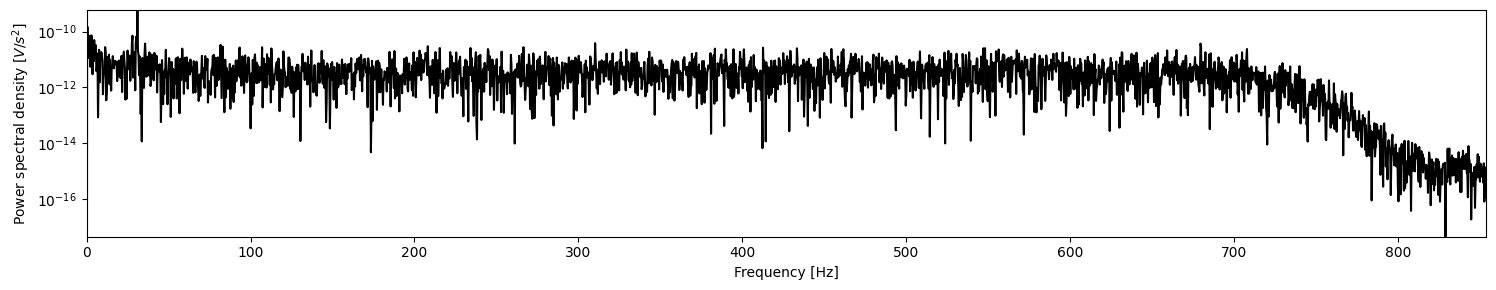

In [9]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output
from scipy.signal import periodogram

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global f,psd,fs
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]
    
    # Extract the raw acceleration data (in volts)
    x0 = np.array(eval(dat[len(t_stamp):]))
    # Calculate power spectral density of the data
    f,psd = periodogram(x0,fs)


sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

psd = np.ones((1,1)) # A dummy array used for creating the plot before we've recieved data
f = np.zeros(1) # A dummy array used for creating the plot before we've recieved data

time_to_disconnect = 20
time_start = time.time()
fs = 1707.76 # Sample rate of the data

# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.semilogy(f,psd[0],c='k')
ax.set_ylabel('Power spectral density [$V/s^2$]')
ax.set_xlabel('Frequency [Hz]')
fg.tight_layout()

while time.time()-time_start<time_to_disconnect:
    if len(f)>1:
        try:
            plotted_data.set_data(f,psd[0]) # Update the plotted data
            ax.set_xlim(np.min(f),np.max(f)) # Update the x-axis of the plot
            ax.set_ylim(np.min(psd[0,1:]),np.max(psd[0,1:])) # Update the y-axis of the plot
            display(fg) # Update the displayed plot
            clear_output(wait=True)
            time.sleep(0.5) # Sleep for 0.5 seconds (helps with rendering plot)
        except:
            time.sleep(0.1)

sio.disconnect()

### Caching data
The bridge server only caches and transfers a maximum of 5 seconds of data. Alongside this, the reciever code does not track whether the current data being transmitted from the bridge has already been received, or what the overlap between data previously received and newly received data is. To collect larger sections of data the code below can be used. This code compares newly received data to previously received data and discards any that has previously been collected.

**Note**: This code is designed for collecting relatively short periods of data. For longer data sets it is advisable to save the data at frequent intervals and compile all data to a single file at a later date.

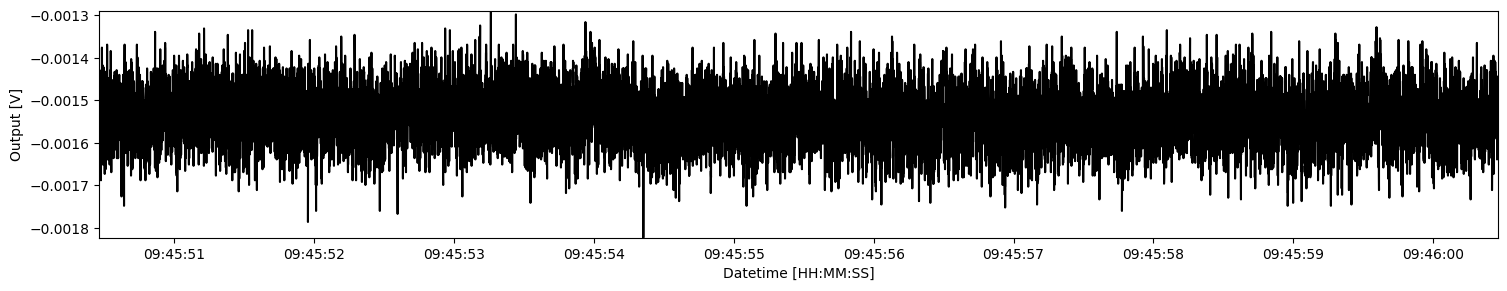

In [10]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global x0_all,t,fs
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]

    x0 = np.array(eval(dat[len(t_stamp):]))

    if len(x0_all)==0:
        x0_all=x0
    else:
        tmp = x0[0,:]
        search_term = x0_all[0,-5:]
        occ = [i for i, a in enumerate(tmp) if a == search_term[0]]
        index=-1
        if len(occ)>0:
            for b in occ:
                if np.all(tmp[b:b+len(search_term)] == search_term):
                    index = b
                    break
            if index==-1:
                x0_all = np.hstack((x0_all,x0))
            else:
                x0_all = np.hstack((x0_all,x0[:,index:]))

        else:
            x0_all = np.hstack((x0_all,x0))
        x0_all = x0_all[:,:max_length]
        # Create a time array using the time stamp
        t_stamp = float(t_stamp) # Convert the time stamp from a string to a float

        t0 = np.arange(t_stamp-(len(x0_all[0])/fs),t_stamp,1/fs)
        # Convert the time from UNIX time to a NumPy datetime format
        t = (t0*1000).astype('datetime64[ms]') # Note we need to multiply by 1000 to convert from seconds to milliseconds


sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

x0_all = []
t = []

time_to_disconnect = 60
time_start = time.time()
fs = 1707.76 # Sample rate of the data
max_length = int(10*fs) # Maximum length of data to cache


# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.plot(0,0,c='k')
ax.set_ylabel('Output [V]')
ax.set_xlabel('Datetime [HH:MM:SS]')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) # Set the formatting of the datetime x-axis
fg.tight_layout()

while time.time()-time_start<time_to_disconnect:
    if len(t)>1:
        try:
            if len(t)==len(x0_all[0]): # This line prevents us trying to plot the acceleration data before the time data has been updated
                plotted_data.set_data(t,x0_all[0]) # Update the plotted data
                ax.set_xlim(np.min(t),np.max(t)) # Update the x-axis of the plot
                ax.set_ylim(np.min(x0_all[0,:]),np.max(x0_all[0,:])) # Update the y-axis of the plot
                display(fg) # Update the displayed plot
                clear_output(wait=True)
                time.sleep(0.5) # Sleep for 0.5 seconds (helps with rendering plot)
        except:
            time.sleep(0.1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9df15425-03c5-4773-8629-248ddacc836e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>